# Pre-operations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-lightning==1.9.4
!pip install einops
!pip install omegaconf
!pip install kornia
!pip install wget
!pip install super-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.1/628.1 kB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=e51716898bad0581bbed5672391fd3b2dd5669add2aa9f2fab16d809ba11541b
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Tue Apr 11 18:57:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Generate sample for FID evaluation

In [1]:
import sys

ROOT_PATH = "/content/drive/MyDrive/Tesi Bardella 2022/LDM_pipeline_porting/Second_stage_LDM"

sys.path.insert(0, ROOT_PATH)

In [2]:
import torch, json, tqdm, os, shutil, numpy as np

from omegaconf import OmegaConf
from modules.util import instantiate_from_config
from models.diffusion.ddim import DDIMSampler
from models.diffusion.plms import PLMSSampler
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

mapping_file = ROOT_PATH + "/mapping.json"


# Load the label literal-discrete mapping
with open(mapping_file, "r") as fin:
    mapping = json.load(fin)
    mapping = {v:k for k, v in mapping}

## Generate New Samples from the LD model

Load the pretrained LDM model

In [3]:
def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    device = torch.device("cuda:0")
    model.to(device)
    model.eval()

    return model


config = OmegaConf.load(ROOT_PATH + "/configs/custom-ldm-cwa-vq-f8.yaml")  
sample_folder = ROOT_PATH + f"/sample/ldm/wikiart"

vq_gan_pretrained_ckpt_path = ROOT_PATH + "/pretrained_model/vq-f8/model.ckpt"
ldm_pretrained_ckpt_path = "/content/drive/MyDrive/Tesi Bardella 2022/LDM_pipeline_porting/Second_stage_LDM/LDM_training/version_12/checkpoints/epoch=299-step=69600.ckpt"
config.model.params.first_stage_config.params["ckpt_path"] = vq_gan_pretrained_ckpt_path

model = load_model_from_config(config, ldm_pretrained_ckpt_path)
sampler = PLMSSampler(model)
#sampler = DDIMSampler(model)

Loading model from /content/drive/MyDrive/Tesi Bardella 2022/LDM_pipeline_porting/Second_stage_LDM/LDM_training/version_12/checkpoints/epoch=299-step=69600.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 394.98 M params.
Keeping EMAs of 628.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Restored from /content/drive/MyDrive/Tesi Bardella 2022/LDM_pipeline_porting/Second_stage_LDM/pretrained_model/vq-f8/model.ckpt with 0 missing and 49 unexpected keys


## VISUALIZATION SAMPLE ONLY


Rendering 1 examples of class '0' in 1000 steps and using s=1.50.
Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 1000 timesteps


PLMS Sampler: 100%|██████████| 1000/1000 [01:30<00:00, 11.02it/s]


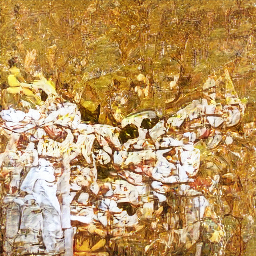

In [8]:
classes = [0]   # define classes to be sampled here
n_samples_per_class = 1
unconditional_class = 8

ddim_steps = 1000
ddim_eta = 0
scale = 1.5  # for unconditional guidance

all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        # Un-conditional class for free classifier sampling
        uc = model.get_learned_conditioning({model.cond_stage_key: torch.tensor(n_samples_per_class*[unconditional_class]).to(model.device)})
        
        for class_label in classes:
            #Conditional class
            print(f"\nRendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
            
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=[4, 32, 32],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc, 
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
img = Image.fromarray(grid.astype(np.uint8))


# Save the producted image
image_name = f"sample_labels_{classes}_scale{scale}_ddim_steps{ddim_steps}_ddim_eta_{ddim_eta}"
image_ext = ".png"
image_number = [0]
for entry in os.listdir(sample_folder):
    if os.path.isfile(os.path.join(sample_folder, entry)):
        splitted_entry = entry[:-len(image_ext)].split("_")
        number = int(splitted_entry.pop(-1))
        if splitted_entry == image_name.split("_"):
            image_number.append(number)


save_folder = sample_folder + "/" + image_name + "_" + str( max(image_number) + 1 )
img.save(save_folder + image_ext)
img

## SAVING THE NEW DATASET

Generate new Sample for a specific class. 
This operation is very time consuming and require a lot of memory.

The problem is we can only take about 15 samples at a time and it takes a few minuts for each batch.

Sampling 10_000 with 200 denoising timesteps takes 11 hours

In [ ]:
# classes = [0,1,2,3,4,5,6,7,8]   # define classes to be sampled here
classes = [0]   # Choose the classes that we want the model sample from

# As said by the official TF FID repo we should generate at least 10000 sample 
# in order to have a FID which is not sub-optimal 

n_samples_per_class = 30000
max_batch_size = 20
unconditional_class = 8

# ddim_steps = [20, 50, 200, 500, 1000]
ddim_steps = [50]
ddim_eta = 0
scale = 2  # for unconditional guidance

for ddim_step in ddim_steps:
  for cls in classes:

    # Create the folder where to save the sample
    sample_already_created = 0
    # save_folder = sample_folder + f"/{ddim_step}_timesteps/{mapping[cls]}"
    save_folder = sample_folder + f"/200_timesteps/{mapping[cls]}"

    if not os.path.exists(save_folder):
      os.makedirs(save_folder)
    else:
      sample_already_created = len([file for file in os.listdir(save_folder) if os.path.isfile(os.path.join(save_folder, file))])

    with torch.no_grad():
      with model.ema_scope():
        
        n_samples_per_class -= sample_already_created
        print(f"\nRendering {n_samples_per_class} examples of class '{cls}' in {ddim_step} steps and using scale= {scale:.2f}")

        if n_samples_per_class > max_batch_size:
          sub_batches = [max_batch_size] * (n_samples_per_class//max_batch_size)

          if n_samples_per_class % max_batch_size != 0 :
            sub_batches.append(n_samples_per_class % max_batch_size)
        else:
          sub_batches = [n_samples_per_class]


        for idx_sub_batch, sub_batch_size in enumerate(sub_batches):
          # Un-conditional class for free classifier sampling
          if scale != 1:
            uc = model.get_learned_conditioning({model.cond_stage_key: torch.tensor(sub_batch_size*[unconditional_class]).to(model.device)}) 
          else:
            None

          #Conditional class
          xc = torch.tensor(sub_batch_size*[cls])
          c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
          
          samples_ddim, _ = sampler.sample(S=ddim_step,
                                          conditioning=c,
                                          batch_size=sub_batch_size,
                                          shape=[4, 32, 32],
                                          verbose=False,
                                          unconditional_guidance_scale=scale,
                                          unconditional_conditioning=uc, 
                                          eta=ddim_eta)

          x_samples_ddim = model.decode_first_stage(samples_ddim)
          x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0).cpu()

          # Save the just generated images and delete
          for idx_img, images in enumerate(torch.chunk(x_samples_ddim, chunks = sub_batch_size, dim = 0)):
              
            final_image = 255. * rearrange(torch.squeeze(images, dim=0), 'c h w -> h w c').numpy()
            final_image = Image.fromarray(final_image.astype(np.uint8))
            image_number = sample_already_created + idx_img + idx_sub_batch * sub_batch_size
            final_image.save(save_folder+ f"/image_{image_number}.png")

          # Delete the sampling tensor to reuse GPU memory istantly
          del x_samples_ddim

# FID COMPUTATION

In [ ]:
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Dataset color subdivision and metadata creation

In [ ]:
from zipfile import ZipFile
import os, json
from tqdm import tqdm

def extractFile(source_file, dest_path):
  if not os.path.exists(dest_path) and os.path.isfile(source_file):
    with ZipFile(source_file, "r") as zipObj:
      zipObj.extractall(dest_path)

dataset_zip_path = "/content/drive/MyDrive/Tesi Bardella 2022/Datasets/wikiart/absfig_filtered_tfr.zip"
dataset_dir = "/content/Datasets/wikiart"

extractFile(dataset_zip_path, dest_path=dataset_dir)

In [ ]:
from tqdm import tqdm
import cv2
from albumentations.augmentations.geometric.resize import Resize

dataset_subdivided_dir = "/content/Datasets/wikiart_subdivided_256"
mapping_file = ROOT_PATH + "/mapping.json"
resize_transform = Resize(height=256, width=256, always_apply=True)

# Load the label literal-discrete mapping
with open(mapping_file, "r") as fin:
    mapping = json.load(fin)
    mapping_r = {v:k for k, v in mapping}

# Load the dataset image path and labels
with open(dataset_dir+"/dataset.json", "r") as fin:
    dataset_info = json.load(fin)["labels"]


# Dataset Subdivision per color label
new_dataset_info = {"labels":[]}
if not os.path.exists(dataset_subdivided_dir):
  for image_path, numerical_label in tqdm(dataset_info):

      img_name, letteral_label = image_path.split("/")[-1], mapping_r[numerical_label]

      image = cv2.imread(dataset_dir + f"/{image_path}")
      image_cvt = resize_transform(image=image)["image"]

      if not os.path.exists(dataset_subdivided_dir + f"/{letteral_label}"):
          os.makedirs(dataset_subdivided_dir + f"/{letteral_label}")
      cv2.imwrite(dataset_subdivided_dir + f"/{letteral_label}/{img_name}", image_cvt)

      new_dataset_info["labels"].append([letteral_label+"/"+ img_name, numerical_label])

  with open(dataset_subdivided_dir+"/dataset.json", "w") as fout:
      json.dump(new_dataset_info, fout)

100%|██████████| 19774/19774 [03:17<00:00, 99.88it/s] 


In [ ]:
# from tqdm import tqdm
# import cv2
# from albumentations.augmentations.geometric.resize import Resize

# src_dir = "/home/ilchrees/data/gitRepo/Thesis/Datasets/wikiart"
# dest_dir = "/home/ilchrees/data/gitRepo/Thesis/Datasets/wikiart_new_subdivision_256"
# resize_transform = Resize(height=256, width=256,always_apply=True)

# for image_path, numerical_label in tqdm(metadata[:None]):
#     letteral_label = label_mapping_r[numerical_label]
#     image_name = image_path.split("/")[-1]

#     image = cv2.imread(src_dir + f"/{image_path}")
#     image_cvt = resize_transform(image=image)["image"]

#     if not os.path.exists(dest_dir + f"/{letteral_label}"):
#         os.makedirs(dest_dir + f"/{letteral_label}")
    
#     cv2.imwrite(dest_dir + f"/{letteral_label}/{image_name}", image_cvt)

In [ ]:
import subprocess
from pprint import pprint
import numpy

labels = ["arancione"]#, "bianco", "blu", "giallo", "nero", "rosso", "verde", "viola"]
device =  "cuda:0"

FIDs = {}
for label in labels:

    original_dataset = dataset_subdivided_dir + f"/{label}"
    generated_dataset = f"/content/drive/MyDrive/Tesi Bardella 2022/LDM_pipeline_porting/Second_stage_LDM/sample/ldm/wikiart/200_timesteps/{label}"

    output = subprocess.run(['python', 
                             '-m', 
                             'pytorch_fid', 
                             original_dataset, 
                             generated_dataset, 
                             "--device", 
                             device], stdout=subprocess.PIPE).stdout.decode('utf-8')
    

    FIDs["_Vs_".join((label, label))] = numpy.float32(output.split(" ")[-1][:-1])

pprint(FIDs)

{'arancione_Vs_arancione': 105.331154}
